# Exploratory Data Analysis

In [14]:
# 1 Setup ───────────────────────────────────────────────────────────────────────
import pathlib, urllib.request, zipfile, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, recall_score


plt.style.use("default")
sns.set_context("notebook")

MLFLOW_EXPERIMENT_NAME = "passcompass_students"
MLFLOW_TRACKING_URI = "http://127.0.0.1:5000"
#MLFLOW_URI = os.getenv("MLFLOW_TRACKING_URI", "http://127.0.0.1:5000")

DATA_DIR = pathlib.Path("../data/students")
DATA_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
# 2 Download & load ────────────────────────────────────────────────────────────
UCI_URL = "https://archive.ics.uci.edu/static/public/320/student+performance.zip"

print("Downloading and extracting...")

# Download and extract the main zip file
with urllib.request.urlopen(UCI_URL) as resp:
    with zipfile.ZipFile(io.BytesIO(resp.read())) as zf:
        zf.extractall(DATA_DIR)

# Now let's check what we have
print("\nFiles in data directory:")
for file in DATA_DIR.glob("*"):
    print(f"- {file.name}")
    # If we find any zip files, extract them
    if file.suffix == '.zip':
        print(f"Extracting {file.name}...")
        with zipfile.ZipFile(file) as zf:
            zf.extractall(DATA_DIR)
        # Remove the zip file after extraction
        file.unlink()

print("\nFinal contents of data directory:")
for file in DATA_DIR.glob("*"):
    print(f"- {file.name}")



Files in data directory:
- .student.zip_old
- student.zip
Extracting student.zip...

Final contents of data directory:
- student-por.csv
- student-merge.R
- .student.zip_old
- student-mat.csv
- student.txt


In [ ]:
math_df = pd.read_csv(DATA_DIR / "student-mat.csv", sep=";")
por_df  = pd.read_csv(DATA_DIR / "student-por.csv", sep=";")

# add course tag before concatenation
math_df["course"] = "math"
por_df["course"]  = "por"

students = pd.concat([math_df, por_df], ignore_index=True)

print(f"Combined shape: {students.shape}")

students.head()

Combined shape: (1044, 34)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,course
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,math
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,math
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,math
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,math
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,math


In [13]:
# 3 Feature engineering ────────────────────────────────────────────────────────
# Create binary target: pass if final grade (G3) ≥ 10 out of 20
students["pass"] = (students["G3"] >= 10).astype(int)

# Drop raw grade columns to make prediction "harder"
students = students.drop(columns=["G1", "G2", "G3"])

print(students["pass"].value_counts())


pass
1    814
0    230
Name: count, dtype: int64


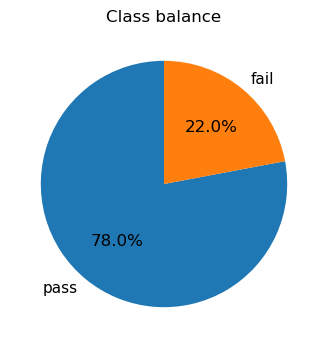

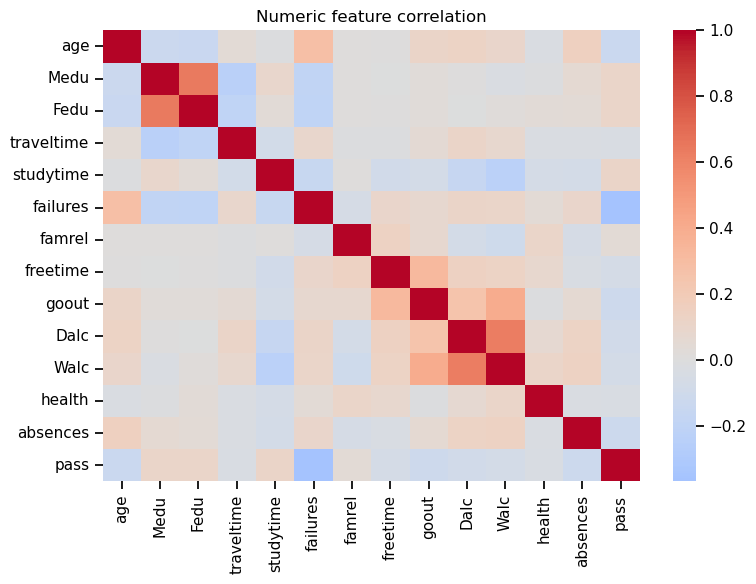

In [15]:
# 4 Exploratory plots ─────────────────────────────────────────────────────────
plt.figure(figsize=(4, 4))
students["pass"].value_counts().plot.pie(
    labels=["pass", "fail"], autopct="%1.1f%%", startangle=90
)
plt.title("Class balance")
plt.ylabel("")
plt.show()

# Numerical correlation heat-map
num_cols = students.select_dtypes("number").columns
plt.figure(figsize=(8, 6))
sns.heatmap(students[num_cols].corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Numeric feature correlation")
plt.tight_layout()


In [16]:
# 5 Baseline model ────────────────────────────────────────────────────────────
X = students.drop(columns="pass")
y = students["pass"]

# Identify categorical vs numeric columns
cat_cols = X.select_dtypes("object").columns.tolist()
num_cols = X.select_dtypes("number").columns.tolist()

preprocess = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="passthrough"
)

clf = Pipeline(
    steps=[
        ("prep", preprocess),
        ("logreg", LogisticRegression(max_iter=1000, solver="lbfgs"))
    ]
)

scores = cross_val_score(clf, X, y, cv=5, scoring="roc_auc")
print(f"Baseline ROC-AUC (5-fold): {scores.mean():.3f} ± {scores.std():.3f}")


Baseline ROC-AUC (5-fold): 0.709 ± 0.076


In [21]:
# 6 Train/test split & report ────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["FAILED", "PASSED"]))

# Optional ROC-AUC on hold-out
y_proba = clf.predict_proba(X_test)[:, 1]
print("Hold-out ROC-AUC:", roc_auc_score(y_test, y_proba).round(3))


              precision    recall  f1-score   support

      FAILED       0.46      0.24      0.31        46
      PASSED       0.81      0.92      0.86       163

    accuracy                           0.77       209
   macro avg       0.63      0.58      0.59       209
weighted avg       0.73      0.77      0.74       209

Hold-out ROC-AUC: 0.733


In [18]:
# 7 Save clean dataset for later notebooks ────────────────────────────────────
CLEAN_PATH = DATA_DIR / "students_clean.csv"

students.to_csv(CLEAN_PATH, index=False)

print("Saved:", CLEAN_PATH.relative_to(DATA_DIR.parent))


Saved: students/students_clean.csv


At this point, I have some sense of the data.
However I would like to explore it more. To do so, I will be creating a hold-out test set now and never peeking at it again.
This is the single best safeguard against “optimism bias”.

In [19]:
# 8 Save train/test splits for later notebooks ─────────────────────────────────

# Re-attach target column for easy CSV export
train_df = X_train.copy()
train_df["pass"] = y_train
test_df  = X_test.copy()
test_df["pass"]  = y_test

DATA_DIR = pathlib.Path("../data/students")
train_path = DATA_DIR / "students_train.csv"
test_path  = DATA_DIR / "students_test.csv"

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path,  index=False)

print(f"Saved {train_path.relative_to(DATA_DIR.parent)}  ({len(train_df)} rows)")
print(f"Saved {test_path.relative_to(DATA_DIR.parent)}   ({len(test_df)} rows)")

Saved students/students_train.csv  (835 rows)
Saved students/students_test.csv   (209 rows)


# MLFlow

- Logging the first experiment for comparing

In [17]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd, mlflow, json
import os


# 9 Train model with MLflow logging ────────────────────────────────────────────

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)  # ← explicit & matches UI
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)


df = pd.read_csv("../data/students/students_train.csv")
y = df.pop("pass")                     # target
X_dicts = df.to_dict(orient="records") # list[dict]

pipe = Pipeline([
    ("vec", DictVectorizer(sparse=True)),
    ("clf", LogisticRegression(max_iter=1000))
])

X_train, X_test, y_train, y_test = train_test_split(
    X_dicts, y, test_size=0.2, stratify=y, random_state=42
)

with mlflow.start_run():
    pipe.fit(X_train, y_train)

    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    # log full classification report (helper you added earlier)
    from passcompass_utils.metrics import log_classification_report
    log_classification_report(y_test, y_pred, prefix="val_")

    # log feature names so you can tune them later
    mlflow.log_param("num_features", len(pipe.named_steps["vec"].get_feature_names_out()))
    mlflow.set_tag("feature_list", json.dumps(
        pipe.named_steps["vec"].get_feature_names_out().tolist()
    ))

    mlflow.sklearn.log_model(pipe, "model", input_example=X_train[0:1])


/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/06/06 16:08:06 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the loggi

🏃 View run blushing-lynx-145 at: http://127.0.0.1:5000/#/experiments/1/runs/78de4f94c34b4dd39922f415950c2a7a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### 1.0 Logistic regression with Hyperopt

In [24]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# ---------- YOUR HELPER IMPORT ---------------------------------------------
from passcompass_utils.metrics import log_classification_report
# ---------------------------------------------------------------------------

# ---------- CONFIG ---------------------------------------------------------

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)


DATA_PATH  = pathlib.Path("../data/students/students_train.csv")  # tweak if needed
SEED       = 42
MAX_EVALS  = 20                # trials per objective
LOG_MODEL  = True             # ⇦ set True if you really want every pipeline saved
model_type = "logistic_regression"  # Random Forest, change if you use a different model
# ---------------------------------------------------------------------------

# ---------- LOAD DATA ------------------------------------------------------
df = pd.read_csv(DATA_PATH)
y  = df.pop("pass")
X_dicts = df.to_dict(orient="records")

X_train, X_val, y_train, y_val = train_test_split(
    X_dicts, y, test_size=0.2, stratify=y, random_state=SEED
)

# ---------- SEARCH SPACE ---------------------------------------------------
space = {
    "C": hp.loguniform("C", np.log(0.001), np.log(100)),
    "penalty": hp.choice("penalty", ["l1", "l2"]),
    "class_weight": hp.choice("class_weight", [None, "balanced"]),
    "solver": "liblinear",          # liblinear handles L1 + L2
    "max_iter": 300,
}

# ---------- FACTORY FOR OBJECTIVE FN --------------------------------------
def make_objective(metric: str):
    """
    metric ∈ {"accuracy", "recall_fail"}
    """
    def objective(params):
        with mlflow.start_run(nested=True):
            mlflow.set_tag("model_type", model_type)
            # --------─ build & train pipeline
            pipe = Pipeline([
                ("vec", DictVectorizer(sparse=True)),
                ("clf", LogisticRegression(**params)),
            ])
            pipe.fit(X_train, y_train)

            # --------─ predictions
            y_pred  = pipe.predict(X_val)

            # --------─ metric of interest
            if metric == "accuracy":
                score = accuracy_score(y_val, y_pred)
            elif metric == "recall_fail":
                score = recall_score(y_val, y_pred, pos_label=0)
            else:
                raise ValueError(metric)

            # --------─ logging (your helpers!)
            from passcompass_utils.metrics import log_classification_report
            
            # log full classification report (helper you added earlier)
            log_classification_report(y_val, y_pred, prefix="val_")

            mlflow.log_params(params)
                


            mlflow.log_param("num_features",
                             len(pipe.named_steps["vec"].get_feature_names_out()))
            mlflow.set_tag("feature_list",
                           json.dumps(pipe.named_steps["vec"]
                                      .get_feature_names_out().tolist()))

            if LOG_MODEL:
                mlflow.sklearn.log_model(pipe, "model",
                                         input_example=[X_train[0]])

            # Hyperopt minimizes → negative score
            return {"loss": -score, "status": STATUS_OK}
    return objective

# ---------- RUN TUNING FOR EACH OBJECTIVE ----------------------------------
for metric_name in ["accuracy", "recall_fail"]:
    trials = Trials()
    with mlflow.start_run(run_name=f"lr_hyperopt_{metric_name}") as parent:
        best = fmin(
            fn=make_objective(metric_name),
            space=space,
            algo=tpe.suggest,
            max_evals=MAX_EVALS,
            trials=trials,
            rstate=np.random.default_rng(SEED),
        )
        mlflow.log_param(f"best_params_{metric_name}", best)
        print(f"Best params for {metric_name}: {best}")

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:36:16 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run unique-dove-27 at: http://127.0.0.1:5000/#/experiments/1/runs/75cee322fe3840f4971c16bc04ffb050

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

  5%|▌         | 1/20 [00:04<01:20,  4.24s/trial, best loss: -0.7724550898203593]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:36:20 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run resilient-shark-865 at: http://127.0.0.1:5000/#/experiments/1/runs/a73f2ad1ab3848c0be84d1923857bdb6

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 10%|█         | 2/20 [00:07<01:10,  3.90s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:36:24 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run honorable-wasp-106 at: http://127.0.0.1:5000/#/experiments/1/runs/000a5fb19727448bb191df587387900f

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 15%|█▌        | 3/20 [00:11<01:05,  3.85s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:36:28 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run dapper-bug-707 at: http://127.0.0.1:5000/#/experiments/1/runs/dd6c90e1a938481d95d0bfbae0357409

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 20%|██        | 4/20 [00:15<00:59,  3.72s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:36:31 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run intelligent-lamb-222 at: http://127.0.0.1:5000/#/experiments/1/runs/67e5d9bd06a74a5bafbecb700c65223c

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 25%|██▌       | 5/20 [00:19<00:57,  3.86s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:36:35 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run capricious-pug-379 at: http://127.0.0.1:5000/#/experiments/1/runs/414b84e8ec8a4e92aeba146f40732c5d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 30%|███       | 6/20 [00:23<00:53,  3.84s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:36:39 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run colorful-pug-771 at: http://127.0.0.1:5000/#/experiments/1/runs/b8b6e561341b45c6af90bb9163abc606

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 35%|███▌      | 7/20 [00:26<00:48,  3.76s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:36:43 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run luminous-ray-707 at: http://127.0.0.1:5000/#/experiments/1/runs/85c7521ec67144d19ed73bdf786c94dc

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 40%|████      | 8/20 [00:30<00:45,  3.79s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:36:46 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run respected-eel-350 at: http://127.0.0.1:5000/#/experiments/1/runs/11037a47dbc64139b340313820497034

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 45%|████▌     | 9/20 [00:34<00:41,  3.74s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:36:50 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run adventurous-lamb-918 at: http://127.0.0.1:5000/#/experiments/1/runs/d87a91c5bcb4407b864a648a8459ff90

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 50%|█████     | 10/20 [00:37<00:36,  3.67s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:36:54 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run peaceful-kit-859 at: http://127.0.0.1:5000/#/experiments/1/runs/6cdbb169b68842e986ad64f5341fc4a2

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 55%|█████▌    | 11/20 [00:41<00:32,  3.61s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:36:57 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run vaunted-fox-341 at: http://127.0.0.1:5000/#/experiments/1/runs/67aff04130f34c5fbf5ab87a581885cb

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 60%|██████    | 12/20 [00:44<00:28,  3.60s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:37:01 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run popular-trout-588 at: http://127.0.0.1:5000/#/experiments/1/runs/b7d70111da694a0c9e8c28b7a7988da4

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 65%|██████▌   | 13/20 [00:48<00:25,  3.62s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:37:04 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run trusting-hawk-885 at: http://127.0.0.1:5000/#/experiments/1/runs/82b5de60d7ce43ffb0665cafc43e8e16

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 70%|███████   | 14/20 [00:52<00:21,  3.61s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:37:08 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run illustrious-lynx-552 at: http://127.0.0.1:5000/#/experiments/1/runs/2bfbdea31e574a5191f69370880e0fc8

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 75%|███████▌  | 15/20 [00:55<00:17,  3.59s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:37:12 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run fearless-conch-269 at: http://127.0.0.1:5000/#/experiments/1/runs/166537615e044f5caa796f0272663ba1

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 80%|████████  | 16/20 [00:59<00:14,  3.68s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:37:15 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run valuable-ray-103 at: http://127.0.0.1:5000/#/experiments/1/runs/cc0e8523d07249389664ad965a303bd2

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 85%|████████▌ | 17/20 [01:02<00:10,  3.64s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:37:19 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run defiant-wasp-698 at: http://127.0.0.1:5000/#/experiments/1/runs/8dc03f04c7ef42eb8ae16db0a69b7b4c

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 90%|█████████ | 18/20 [01:06<00:07,  3.60s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:37:22 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run silent-goat-552 at: http://127.0.0.1:5000/#/experiments/1/runs/4affdb2965ab46d1b50857054a4fca28

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 95%|█████████▌| 19/20 [01:10<00:03,  3.63s/trial, best loss: -0.8263473053892215]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:37:26 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run dapper-mare-23 at: http://127.0.0.1:5000/#/experiments/1/runs/d53259d19f794ae8bd20041fc7a224b1

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

100%|██████████| 20/20 [01:13<00:00,  3.69s/trial, best loss: -0.8263473053892215]
Best params for accuracy: {'C': np.float64(1.0996280532604517), 'class_weight': np.int64(0), 'penalty': np.int64(1)}
🏃 View run lr_hyperopt_accuracy at: http://127.0.0.1:5000/#/experiments/1/runs/8c9cb103d64740c9926474fce888d03e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:37:30 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run illustrious-lamb-672 at: http://127.0.0.1:5000/#/experiments/1/runs/eb8bcd0bd9744d7da72c31b1084c5de6

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

  5%|▌         | 1/20 [00:03<01:08,  3.63s/trial, best loss: -0.7027027027027027]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:37:33 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run shivering-cat-78 at: http://127.0.0.1:5000/#/experiments/1/runs/8599cd6f88b2432193048f1c2afd3adc

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 10%|█         | 2/20 [00:07<01:05,  3.66s/trial, best loss: -0.7027027027027027]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:37:37 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run intrigued-zebra-888 at: http://127.0.0.1:5000/#/experiments/1/runs/670b27c2a04f4b75a93f698e94d7a62e

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 15%|█▌        | 3/20 [00:11<01:03,  3.75s/trial, best loss: -0.7027027027027027]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:37:41 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run placid-fish-808 at: http://127.0.0.1:5000/#/experiments/1/runs/50e62ae7e6ab4d5d9f4a3b7247b0c1fc

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 20%|██        | 4/20 [00:14<00:59,  3.71s/trial, best loss: -0.7027027027027027]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:37:45 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run enchanting-finch-823 at: http://127.0.0.1:5000/#/experiments/1/runs/ac4dcde9e8b140df868eb1e180d3c0bf

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 25%|██▌       | 5/20 [00:18<00:56,  3.75s/trial, best loss: -1.0]               

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:37:48 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run vaunted-perch-591 at: http://127.0.0.1:5000/#/experiments/1/runs/6d50ba8fed524c4eb4a482550f32e9f4

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1      

 30%|███       | 6/20 [00:22<00:51,  3.68s/trial, best loss: -1.0]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:37:52 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run clean-bass-872 at: http://127.0.0.1:5000/#/experiments/1/runs/789a42773cf644678959568f09e8adfc

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1      

 35%|███▌      | 7/20 [00:25<00:47,  3.64s/trial, best loss: -1.0]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:37:56 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run honorable-cod-519 at: http://127.0.0.1:5000/#/experiments/1/runs/afd6f7d00cf241d4927cc2e9e15d2d7c

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1      

 40%|████      | 8/20 [00:29<00:43,  3.65s/trial, best loss: -1.0]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:37:59 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run fun-stoat-840 at: http://127.0.0.1:5000/#/experiments/1/runs/b092eafa15124163bf4f55a80782fb0e

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1      

 45%|████▌     | 9/20 [00:33<00:40,  3.65s/trial, best loss: -1.0]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:38:03 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run calm-stoat-148 at: http://127.0.0.1:5000/#/experiments/1/runs/5dbd98a5830e4ce7bf4c652d376317f7

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1      

 50%|█████     | 10/20 [00:36<00:36,  3.64s/trial, best loss: -1.0]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:38:06 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run resilient-sow-838 at: http://127.0.0.1:5000/#/experiments/1/runs/4259d8e40bc24d8a9477b263e2835c60

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1       

 55%|█████▌    | 11/20 [00:40<00:32,  3.66s/trial, best loss: -1.0]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:38:10 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run thoughtful-bass-550 at: http://127.0.0.1:5000/#/experiments/1/runs/6272f1773aed4c1aa5f8410a52a3bfc6

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1       

 60%|██████    | 12/20 [00:44<00:29,  3.65s/trial, best loss: -1.0]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:38:14 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run nervous-donkey-272 at: http://127.0.0.1:5000/#/experiments/1/runs/666dddf275894235825f2832c2a02caa

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1       

 65%|██████▌   | 13/20 [00:47<00:25,  3.66s/trial, best loss: -1.0]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:38:17 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run spiffy-dove-236 at: http://127.0.0.1:5000/#/experiments/1/runs/eb7315ed024d4a84b90ac275e7967a2d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1       

 70%|███████   | 14/20 [00:51<00:21,  3.64s/trial, best loss: -1.0]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:38:21 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run gaudy-fish-584 at: http://127.0.0.1:5000/#/experiments/1/runs/fdd898937ffe4bcba6e82c6ae18257f9

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1       

 75%|███████▌  | 15/20 [00:54<00:18,  3.62s/trial, best loss: -1.0]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:38:25 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run rare-eel-388 at: http://127.0.0.1:5000/#/experiments/1/runs/fdfdcea4ab3942cb970bb0ff2d1f2958

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1       

 80%|████████  | 16/20 [00:58<00:14,  3.69s/trial, best loss: -1.0]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:38:28 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run serious-kite-844 at: http://127.0.0.1:5000/#/experiments/1/runs/d817278abb9742a8a21b071a3b80129b

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1       

 85%|████████▌ | 17/20 [01:02<00:11,  3.69s/trial, best loss: -1.0]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:38:32 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run stately-gull-802 at: http://127.0.0.1:5000/#/experiments/1/runs/885746befb7a427a89ece05c18882aaf

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1       

 90%|█████████ | 18/20 [01:05<00:07,  3.64s/trial, best loss: -1.0]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:38:36 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run enchanting-crane-243 at: http://127.0.0.1:5000/#/experiments/1/runs/56209e7e5275433383b003759a5a857a

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1       

 95%|█████████▌| 19/20 [01:09<00:03,  3.68s/trial, best loss: -1.0]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:38:40 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run painted-grub-531 at: http://127.0.0.1:5000/#/experiments/1/runs/d5a67ba4ea974358a0840e72cf72ed70

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1       

100%|██████████| 20/20 [01:13<00:00,  3.69s/trial, best loss: -1.0]
Best params for recall_fail: {'C': np.float64(0.0030424484494981857), 'class_weight': np.int64(1), 'penalty': np.int64(0)}
🏃 View run lr_hyperopt_recall_fail at: http://127.0.0.1:5000/#/experiments/1/runs/1fd046e7852642d3b5cfb735c1b21d82
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### 2.0 Random Forest with Hyperopt

In [25]:
from passcompass_utils.metrics import log_classification_report
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score

# ---------------------- CONFIG --------------------------------------------
MLFLOW_URI  = os.getenv("MLFLOW_TRACKING_URI", "http://127.0.0.1:5000")
mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment("passcompass_students")

DATA_PATH   = pathlib.Path("../data/students/students_train.csv")
SEED        = 42
MAX_EVALS   = 30            # trials per objective
LOG_MODEL   = True         # set True to persist every RF pipeline
model_type = "RandomForest" 

# ---------------------------------------------------------------------------

# ---------------------- DATA ----------------------------------------------
df = pd.read_csv(DATA_PATH)
y  = df.pop("pass")
X_dicts = df.to_dict(orient="records")

X_train, X_val, y_train, y_val = train_test_split(
    X_dicts, y, test_size=0.2, stratify=y, random_state=SEED
)

# ---------------------- SEARCH SPACE --------------------------------------
space = {
    "n_estimators":     hp.quniform("n_estimators", 100, 800, 50),
    "max_depth":        hp.choice("max_depth", [None] + list(range(5, 21, 3))),
    "min_samples_split": hp.quniform("min_samples_split", 2, 10, 1),
    "min_samples_leaf":  hp.quniform("min_samples_leaf", 1, 5, 1),
    # valid choices: int, float (0–1], "sqrt", "log2", None
    "max_features":     hp.choice("max_features",
                                  [None, "sqrt", "log2", 0.3, 0.5, 0.8]),
    "class_weight":     hp.choice("class_weight", [None, "balanced"]),
    "bootstrap":        hp.choice("bootstrap", [True, False]),
}

def cast_int(params, keys):
    """Hyperopt returns floats for quniform; cast selected keys to int."""
    for k in keys:
        if k in params:
            params[k] = int(params[k])
    return params

# ---------------------- OBJECTIVE FACTORY ----------------------------------
def make_objective(metric: str):
    def objective(params):
        params = cast_int(params, ["n_estimators", "min_samples_split", "min_samples_leaf"])
        with mlflow.start_run(nested=True):
            mlflow.set_tag("model_type", model_type)
            # ---- Build pipeline ----
            pipe = Pipeline([
                ("vec", DictVectorizer(sparse=True)),
                ("clf", RandomForestClassifier(
                    random_state=SEED,
                    n_jobs=-1,
                    **params
                )),
            ])
            pipe.fit(X_train, y_train)

            # ---- Predictions ----
            y_pred = pipe.predict(X_val)

            if metric == "accuracy":
                score = accuracy_score(y_val, y_pred)
            elif metric == "recall_fail":
                score = recall_score(y_val, y_pred, pos_label=0)
            else:
                raise ValueError(metric)

            # ---- Logging ----
            mlflow.log_params(params)
            log_classification_report(y_val, y_pred, prefix="val_")

            mlflow.log_param("num_features",
                             len(pipe.named_steps["vec"].get_feature_names_out()))
            mlflow.set_tag("feature_list",
                           json.dumps(pipe.named_steps["vec"]
                                      .get_feature_names_out().tolist()))

            if LOG_MODEL:
                mlflow.sklearn.log_model(pipe, "model",
                                         input_example=[X_train[0]])

            return {"loss": -score, "status": STATUS_OK}
    return objective

# ---------------------- RUN TUNING ----------------------------------------
for metric in ["accuracy", "recall_fail"]:
    trials = Trials()
    with mlflow.start_run(run_name=f"rf_hyperopt_{metric}") as parent:
        best = fmin(
            fn=make_objective(metric),
            space=space,
            algo=tpe.suggest,
            max_evals=MAX_EVALS,
            trials=trials,
            rstate=np.random.default_rng(SEED),
        )
        mlflow.log_param(f"best_params_{metric}", best)
        print(f"Best params for {metric}: {best}")

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:38:45 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run brawny-shad-309 at: http://127.0.0.1:5000/#/experiments/1/runs/8bcf26f74986499ba4a6cae48cef7469

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

  3%|▎         | 1/30 [00:04<02:22,  4.91s/trial, best loss: -0.8023952095808383]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:38:49 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run youthful-bass-225 at: http://127.0.0.1:5000/#/experiments/1/runs/dcb6f651a0a34528872c7af7f282ce77

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

  7%|▋         | 2/30 [00:09<02:05,  4.49s/trial, best loss: -0.8023952095808383]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:38:53 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run dapper-shrew-95 at: http://127.0.0.1:5000/#/experiments/1/runs/842506fc5d8f40f58303d18c7681406e

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 10%|█         | 3/30 [00:13<01:56,  4.33s/trial, best loss: -0.8023952095808383]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:38:58 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run bright-doe-996 at: http://127.0.0.1:5000/#/experiments/1/runs/c7afa5bf57a0434d9216f2b0a4fa319d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 13%|█▎        | 4/30 [00:17<01:53,  4.38s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:39:02 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run auspicious-calf-628 at: http://127.0.0.1:5000/#/experiments/1/runs/719333b9431845258d341d73aa78005e

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 17%|█▋        | 5/30 [00:22<01:51,  4.44s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:39:07 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run upset-cat-993 at: http://127.0.0.1:5000/#/experiments/1/runs/dac139530fa342d3be5541ab036bc949

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 20%|██        | 6/30 [00:27<01:50,  4.61s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:39:12 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run abrasive-crow-918 at: http://127.0.0.1:5000/#/experiments/1/runs/a2ae3709c132449a92ec0f1d3a99c0d3

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 23%|██▎       | 7/30 [00:31<01:47,  4.67s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:39:16 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run tasteful-calf-849 at: http://127.0.0.1:5000/#/experiments/1/runs/5de6abfba9784b69a5f8b8bd319daed5

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 27%|██▋       | 8/30 [00:36<01:38,  4.48s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:39:21 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run spiffy-quail-941 at: http://127.0.0.1:5000/#/experiments/1/runs/3e6e135a3f2d433fa8cc01c504b8de44

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 30%|███       | 9/30 [00:40<01:35,  4.53s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:39:25 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run glamorous-eel-340 at: http://127.0.0.1:5000/#/experiments/1/runs/5c9d86c9f20c4454af9e9ee53a1f4a35

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 33%|███▎      | 10/30 [00:44<01:28,  4.41s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:39:29 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run mercurial-cat-190 at: http://127.0.0.1:5000/#/experiments/1/runs/1a6bcc9473964476a322e8fb1285bb8c

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 37%|███▋      | 11/30 [00:48<01:20,  4.25s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:39:33 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run legendary-toad-998 at: http://127.0.0.1:5000/#/experiments/1/runs/5ccaff3cf8e04672bc5485830e7e64bf

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 40%|████      | 12/30 [00:53<01:19,  4.43s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:39:38 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run crawling-toad-385 at: http://127.0.0.1:5000/#/experiments/1/runs/77816be23edb4d19bacc75c3b7f67267

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 43%|████▎     | 13/30 [00:58<01:16,  4.51s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:39:42 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run gaudy-bee-463 at: http://127.0.0.1:5000/#/experiments/1/runs/a49531f42a0c479c8845e61c98f87ee1

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 47%|████▋     | 14/30 [01:02<01:11,  4.49s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:39:47 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run monumental-cat-737 at: http://127.0.0.1:5000/#/experiments/1/runs/33c0aee38040486ebba7e837233105fc

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 50%|█████     | 15/30 [01:07<01:07,  4.48s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:39:52 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run popular-robin-497 at: http://127.0.0.1:5000/#/experiments/1/runs/4c6f2bcfc00243a39e2d01a37ded952f

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 53%|█████▎    | 16/30 [01:12<01:04,  4.59s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:39:57 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run skittish-crow-964 at: http://127.0.0.1:5000/#/experiments/1/runs/e8b574fbea344abea3fd26c2ad2872b1

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 57%|█████▋    | 17/30 [01:17<01:02,  4.82s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:40:02 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run handsome-shad-638 at: http://127.0.0.1:5000/#/experiments/1/runs/6ac93c98f8e34a369c82d8649d5d2239

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 60%|██████    | 18/30 [01:21<00:56,  4.72s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:40:06 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run burly-pig-445 at: http://127.0.0.1:5000/#/experiments/1/runs/f1579f6ffdb54e139e13a7f8d772e6f0

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 63%|██████▎   | 19/30 [01:26<00:50,  4.57s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:40:10 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run bemused-panda-838 at: http://127.0.0.1:5000/#/experiments/1/runs/08a753f624f148d89710f8b5bc4de4f5

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 67%|██████▋   | 20/30 [01:30<00:45,  4.58s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:40:15 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run powerful-croc-550 at: http://127.0.0.1:5000/#/experiments/1/runs/6c48b20dbd614dc0962973c3e832b558

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 70%|███████   | 21/30 [01:35<00:42,  4.68s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:40:20 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run intelligent-pug-406 at: http://127.0.0.1:5000/#/experiments/1/runs/420b9e7de6414ba5a2d0708f18558a93

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 73%|███████▎  | 22/30 [01:40<00:37,  4.70s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:40:25 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run clean-ant-140 at: http://127.0.0.1:5000/#/experiments/1/runs/3137f2aed62c442e842dffe159111585

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 77%|███████▋  | 23/30 [01:45<00:33,  4.84s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:40:30 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run omniscient-croc-106 at: http://127.0.0.1:5000/#/experiments/1/runs/777737fbba6d40be9479e1aef2c98aaf

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 80%|████████  | 24/30 [01:50<00:28,  4.80s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:40:35 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run resilient-lark-118 at: http://127.0.0.1:5000/#/experiments/1/runs/16db7bb1801f43eb8f7bf7ad0c4de67a

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 83%|████████▎ | 25/30 [01:54<00:23,  4.78s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:40:40 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run clumsy-deer-303 at: http://127.0.0.1:5000/#/experiments/1/runs/8b2e3c5ae7214ab9aad2f49b1a8764cb

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 87%|████████▋ | 26/30 [02:00<00:19,  4.91s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:40:45 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run tasteful-skink-573 at: http://127.0.0.1:5000/#/experiments/1/runs/e10a8e2f06d2469bbac4a85d933c3450

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 90%|█████████ | 27/30 [02:04<00:14,  4.77s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:40:49 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run enchanting-doe-552 at: http://127.0.0.1:5000/#/experiments/1/runs/1446a12ea711468dae885a61ec6fb844

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 93%|█████████▎| 28/30 [02:09<00:09,  4.69s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:40:54 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run righteous-yak-653 at: http://127.0.0.1:5000/#/experiments/1/runs/452ecb34702e478cad8b17d51b89d056

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 97%|█████████▋| 29/30 [02:13<00:04,  4.64s/trial, best loss: -0.8502994011976048]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:40:59 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run awesome-bug-822 at: http://127.0.0.1:5000/#/experiments/1/runs/062c440562f64f1ba1c360a2cc5081d5

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

100%|██████████| 30/30 [02:18<00:00,  4.62s/trial, best loss: -0.8502994011976048]
Best params for accuracy: {'bootstrap': np.int64(0), 'class_weight': np.int64(1), 'max_depth': np.int64(4), 'max_features': np.int64(1), 'min_samples_leaf': np.float64(3.0), 'min_samples_split': np.float64(4.0), 'n_estimators': np.float64(400.0)}
🏃 View run hyperopt_rf_accuracy at: http://127.0.0.1:5000/#/experiments/1/runs/a2a637e5b7a84efeb7fac032bb27f3ac
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:41:03 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run skillful-fly-458 at: http://127.0.0.1:5000/#/experiments/1/runs/f227de0f201449fcb3cc39016a3b530c

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

  3%|▎         | 1/30 [00:04<02:08,  4.45s/trial, best loss: -0.16216216216216217]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:41:07 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run merciful-doe-733 at: http://127.0.0.1:5000/#/experiments/1/runs/c3bf3fcb506f41ed9ac87d60bef2c001

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

  7%|▋         | 2/30 [00:08<02:01,  4.33s/trial, best loss: -0.4594594594594595] 

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:41:11 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run gregarious-stag-137 at: http://127.0.0.1:5000/#/experiments/1/runs/3d7a24e89af2421e8f956816ec1878bf

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 10%|█         | 3/30 [00:12<01:53,  4.19s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:41:16 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run defiant-ram-268 at: http://127.0.0.1:5000/#/experiments/1/runs/f9e237cd73d649eca1f4307526ec58e9

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 13%|█▎        | 4/30 [00:17<01:51,  4.29s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:41:20 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run zealous-snail-843 at: http://127.0.0.1:5000/#/experiments/1/runs/99d3be8b199b46c7b1107d46ccc2f996

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 17%|█▋        | 5/30 [00:21<01:49,  4.40s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:41:25 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run angry-yak-138 at: http://127.0.0.1:5000/#/experiments/1/runs/277562b072d14c09970030dc90bb0007

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 20%|██        | 6/30 [00:26<01:48,  4.51s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:41:30 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run powerful-slug-621 at: http://127.0.0.1:5000/#/experiments/1/runs/1feffed5e7824e6e9aa4418c84ff5c5c

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 23%|██▎       | 7/30 [00:31<01:45,  4.61s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:41:34 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run adaptable-fawn-661 at: http://127.0.0.1:5000/#/experiments/1/runs/8542b5872f8040f7b2f2bfdfaf11211f

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 27%|██▋       | 8/30 [00:35<01:36,  4.39s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:41:38 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run angry-midge-279 at: http://127.0.0.1:5000/#/experiments/1/runs/0693d79994214998ab27f61f2ed789c7

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 30%|███       | 9/30 [00:39<01:34,  4.49s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:41:43 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run stylish-tern-915 at: http://127.0.0.1:5000/#/experiments/1/runs/b16e618b8e1a4dada61cfcb57f9c181d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 33%|███▎      | 10/30 [00:44<01:31,  4.58s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:41:47 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run clean-mouse-955 at: http://127.0.0.1:5000/#/experiments/1/runs/0cc93ebe2a774eb6905067b64cb7ecd5

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 37%|███▋      | 11/30 [00:48<01:22,  4.36s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:41:52 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run calm-snake-399 at: http://127.0.0.1:5000/#/experiments/1/runs/cb375ccc1dc341c0aea8ac60ff5cb85d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 40%|████      | 12/30 [00:53<01:21,  4.53s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:41:56 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run receptive-loon-275 at: http://127.0.0.1:5000/#/experiments/1/runs/a51db63f3de140d6a9e24f5b1320e1d2

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 43%|████▎     | 13/30 [00:57<01:15,  4.41s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:42:00 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run whimsical-moth-148 at: http://127.0.0.1:5000/#/experiments/1/runs/4a80db3598504c5493884327a7e949d7

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 47%|████▋     | 14/30 [01:01<01:08,  4.26s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:42:04 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run melodic-koi-55 at: http://127.0.0.1:5000/#/experiments/1/runs/0301c71381244e948397af38fde9f84b

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 50%|█████     | 15/30 [01:05<01:03,  4.21s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:42:09 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run efficient-snipe-725 at: http://127.0.0.1:5000/#/experiments/1/runs/b9f8845753e84ee3a40dd88a0eb189ab

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 53%|█████▎    | 16/30 [01:10<01:00,  4.34s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:42:14 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run unleashed-crow-877 at: http://127.0.0.1:5000/#/experiments/1/runs/18875742a64b446785ea4e2fd3d5ce92

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 57%|█████▋    | 17/30 [01:15<00:58,  4.50s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:42:18 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run treasured-sheep-216 at: http://127.0.0.1:5000/#/experiments/1/runs/a5af36ae605a40d6964ad42bef956a73

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 60%|██████    | 18/30 [01:19<00:54,  4.52s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:42:22 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run gentle-pig-675 at: http://127.0.0.1:5000/#/experiments/1/runs/67a3feb1a0694b0dbee2bc00ccd24d10

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 63%|██████▎   | 19/30 [01:23<00:48,  4.41s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:42:27 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run gifted-fish-668 at: http://127.0.0.1:5000/#/experiments/1/runs/a8409f108a494f0382394ad645b8a847

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 67%|██████▋   | 20/30 [01:28<00:43,  4.38s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:42:31 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run stately-penguin-45 at: http://127.0.0.1:5000/#/experiments/1/runs/f6cbd2061fba49f7a77a311394e13e4d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 70%|███████   | 21/30 [01:32<00:39,  4.40s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:42:35 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run gaudy-zebra-425 at: http://127.0.0.1:5000/#/experiments/1/runs/0736283c4c11430cb0a7d17dfd6089e2

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 73%|███████▎  | 22/30 [01:36<00:34,  4.28s/trial, best loss: -0.6486486486486487]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:42:39 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run colorful-auk-724 at: http://127.0.0.1:5000/#/experiments/1/runs/1bc3a4909b9544148372be23b7ff1d58

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 77%|███████▋  | 23/30 [01:40<00:29,  4.19s/trial, best loss: -0.6756756756756757]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:42:43 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run hilarious-moose-364 at: http://127.0.0.1:5000/#/experiments/1/runs/8e8ec5aecfc642e09dd9b469f24c3b27

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 80%|████████  | 24/30 [01:45<00:25,  4.27s/trial, best loss: -0.6756756756756757]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:42:48 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run gifted-frog-949 at: http://127.0.0.1:5000/#/experiments/1/runs/0e03803ffbfe4c209e84b4f908502a49

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 83%|████████▎ | 25/30 [01:48<00:20,  4.14s/trial, best loss: -0.6756756756756757]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:42:51 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run overjoyed-flea-467 at: http://127.0.0.1:5000/#/experiments/1/runs/e6e33cf096544cda89bccbd0edae28f3

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 87%|████████▋ | 26/30 [01:52<00:16,  4.06s/trial, best loss: -0.6756756756756757]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:42:56 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run stately-mouse-919 at: http://127.0.0.1:5000/#/experiments/1/runs/4ead4d53c06d4d298e83e63f5438a0bb

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 90%|█████████ | 27/30 [01:57<00:13,  4.35s/trial, best loss: -0.6756756756756757]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:43:00 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run silent-lark-931 at: http://127.0.0.1:5000/#/experiments/1/runs/87f9beb2d7db4dd586cf27d552b4d87d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 93%|█████████▎| 28/30 [02:01<00:08,  4.22s/trial, best loss: -0.6756756756756757]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:43:04 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run receptive-crane-857 at: http://127.0.0.1:5000/#/experiments/1/runs/8e902d4920e14a2cb419a7a48cbae1a9

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 97%|█████████▋| 29/30 [02:05<00:04,  4.15s/trial, best loss: -0.6756756756756757]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:43:09 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run popular-hound-974 at: http://127.0.0.1:5000/#/experiments/1/runs/3b3e9664f56c4a019f956f545420c4f8

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

100%|██████████| 30/30 [02:10<00:00,  4.34s/trial, best loss: -0.6756756756756757]
Best params for recall_fail: {'bootstrap': np.int64(1), 'class_weight': np.int64(1), 'max_depth': np.int64(1), 'max_features': np.int64(1), 'min_samples_leaf': np.float64(3.0), 'min_samples_split': np.float64(2.0), 'n_estimators': np.float64(100.0)}
🏃 View run hyperopt_rf_recall_fail at: http://127.0.0.1:5000/#/experiments/1/runs/ac190e75674a438e8a463b2eea140053
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### 3.0 Gradient Boosting Classifier

In [26]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score

from passcompass_utils.metrics import log_classification_report

# ------------------------- CONFIG ------------------------------------------
MLFLOW_URI = os.getenv("MLFLOW_TRACKING_URI", "http://127.0.0.1:5000")
mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment("passcompass_students")

DATA_PATH  = pathlib.Path("../data/students/students_train.csv")
SEED       = 42
MAX_EVALS  = 30            # trials per objective
LOG_MODEL  = True         # flip to True to persist every model
# ---------------------------------------------------------------------------

# ------------------------- DATA -------------------------------------------
df = pd.read_csv(DATA_PATH)
y  = df.pop("pass")
X_dicts = df.to_dict(orient="records")

X_train, X_val, y_train, y_val = train_test_split(
    X_dicts, y, test_size=0.2, stratify=y, random_state=SEED
)

# --------------------- HYPERPARAMETER SPACE -------------------------------
space = {
    "n_estimators":     hp.quniform("n_estimators", 50, 400, 25),
    "learning_rate":    hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
    "max_depth":        hp.quniform("max_depth", 1, 5, 1),
    "min_samples_split": hp.quniform("min_samples_split", 2, 10, 1),
    "min_samples_leaf":  hp.quniform("min_samples_leaf", 1, 5, 1),
    "subsample":        hp.uniform("subsample", 0.6, 1.0),
    "max_features":     hp.choice("max_features", [None, "sqrt", "log2"]),
}

def cast_int(params, keys):
    for k in keys:
        if k in params:
            params[k] = int(params[k])
    return params

# --------------------- OBJECTIVE FACTORY ----------------------------------
def make_objective(metric: str):
    def objective(params):
        params = cast_int(
            params,
            ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"]
        )
        with mlflow.start_run(nested=True):
            mlflow.set_tag("model_type", "GradientBoosting")

            pipe = Pipeline([
                ("vec", DictVectorizer(sparse=True)),
                ("clf", GradientBoostingClassifier(
                    random_state=SEED,
                    **params
                )),
            ])
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_val)

            if metric == "accuracy":
                score = accuracy_score(y_val, y_pred)
            elif metric == "recall_fail":
                score = recall_score(y_val, y_pred, pos_label=0)
            else:
                raise ValueError(metric)

            mlflow.log_params(params)
            log_classification_report(y_val, y_pred, prefix="val_")

            mlflow.log_param("num_features",
                             len(pipe.named_steps["vec"].get_feature_names_out()))
            mlflow.set_tag("feature_list",
                           json.dumps(pipe.named_steps["vec"]
                                      .get_feature_names_out().tolist()))

            if LOG_MODEL:
                mlflow.sklearn.log_model(pipe, "model",
                                         input_example=[X_train[0]])

            return {"loss": -score, "status": STATUS_OK}
    return objective

# --------------------- RUN TUNING -----------------------------------------
for metric in ["accuracy", "recall_fail"]:
    trials = Trials()
    with mlflow.start_run(run_name=f"gb_hyperopt_{metric}") as parent:
        best = fmin(
            fn=make_objective(metric),
            space=space,
            algo=tpe.suggest,
            max_evals=MAX_EVALS,
            trials=trials,
            rstate=np.random.default_rng(SEED),
        )
        mlflow.log_param(f"best_params_{metric}", best)
        print(f"Best params for {metric}: {best}")

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:43:13 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run fun-bass-754 at: http://127.0.0.1:5000/#/experiments/1/runs/3ef1df32d8134741ba622484398a436a

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

  3%|▎         | 1/30 [00:04<01:58,  4.09s/trial, best loss: -0.8083832335329342]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:43:17 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run bemused-dog-295 at: http://127.0.0.1:5000/#/experiments/1/runs/c43752b19d284051848aec7792e5bc63

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

  7%|▋         | 2/30 [00:07<01:51,  3.97s/trial, best loss: -0.8083832335329342]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:43:21 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run orderly-kit-9 at: http://127.0.0.1:5000/#/experiments/1/runs/519da4d1ab44432b9c2c7aaa3f5eff4b

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 10%|█         | 3/30 [00:11<01:45,  3.92s/trial, best loss: -0.8083832335329342]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:43:25 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run angry-lynx-30 at: http://127.0.0.1:5000/#/experiments/1/runs/ead64ba3b1d545eeb265f0cc78651bcf

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 13%|█▎        | 4/30 [00:15<01:42,  3.96s/trial, best loss: -0.8083832335329342]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:43:29 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run delicate-steed-52 at: http://127.0.0.1:5000/#/experiments/1/runs/e5a76fcf238a4f0481c428aea4560c2a

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 17%|█▋        | 5/30 [00:19<01:39,  3.97s/trial, best loss: -0.8083832335329342]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:43:33 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run casual-moose-817 at: http://127.0.0.1:5000/#/experiments/1/runs/3e43d1d729bc4b419ded0b9fd18f7343

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 20%|██        | 6/30 [00:23<01:34,  3.93s/trial, best loss: -0.8083832335329342]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:43:37 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run nervous-eel-278 at: http://127.0.0.1:5000/#/experiments/1/runs/0d17c7d5836247faa91d60b8153155c7

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 23%|██▎       | 7/30 [00:28<01:35,  4.17s/trial, best loss: -0.8083832335329342]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:43:42 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run sassy-lamb-966 at: http://127.0.0.1:5000/#/experiments/1/runs/0754bd02c67d479f8be740b0bb4b6183

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 27%|██▋       | 8/30 [00:33<01:38,  4.47s/trial, best loss: -0.8083832335329342]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:43:46 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run mercurial-cow-49 at: http://127.0.0.1:5000/#/experiments/1/runs/83e834ae30a44bf9803ac0c7e9222607

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 30%|███       | 9/30 [00:37<01:31,  4.38s/trial, best loss: -0.8083832335329342]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:43:51 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run bold-perch-911 at: http://127.0.0.1:5000/#/experiments/1/runs/5a6554bc825e484fb8ee745815d576f0

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 33%|███▎      | 10/30 [00:41<01:26,  4.32s/trial, best loss: -0.8143712574850299]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:43:54 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run suave-roo-469 at: http://127.0.0.1:5000/#/experiments/1/runs/1bb47b2f7ab343eeb6f8e4b17238a5f6

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 37%|███▋      | 11/30 [00:45<01:19,  4.21s/trial, best loss: -0.8143712574850299]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:43:59 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run sneaky-moose-194 at: http://127.0.0.1:5000/#/experiments/1/runs/138ee8e3ac424eebb664a39b527b9970

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 40%|████      | 12/30 [00:50<01:16,  4.28s/trial, best loss: -0.8143712574850299]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:44:03 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run capricious-fawn-579 at: http://127.0.0.1:5000/#/experiments/1/runs/4389f49f88f84f12a8a148f0e552d4f0

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 43%|████▎     | 13/30 [00:54<01:11,  4.21s/trial, best loss: -0.8143712574850299]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:44:07 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run placid-vole-94 at: http://127.0.0.1:5000/#/experiments/1/runs/92a04424b5bc44e7a70fc0d16dc5037e

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 47%|████▋     | 14/30 [00:58<01:06,  4.16s/trial, best loss: -0.8203592814371258]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:44:11 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run youthful-owl-104 at: http://127.0.0.1:5000/#/experiments/1/runs/34c296c058ab4a65bc7319e407fe643c

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 50%|█████     | 15/30 [01:02<01:02,  4.17s/trial, best loss: -0.8203592814371258]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:44:15 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run unequaled-steed-825 at: http://127.0.0.1:5000/#/experiments/1/runs/00e35bfbf1df48739e421528cd5e588e

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 53%|█████▎    | 16/30 [01:06<00:58,  4.16s/trial, best loss: -0.8203592814371258]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:44:20 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run masked-quail-502 at: http://127.0.0.1:5000/#/experiments/1/runs/360901cbcd3e441fa91dee7cecf0c533

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 57%|█████▋    | 17/30 [01:10<00:54,  4.18s/trial, best loss: -0.8203592814371258]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:44:24 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run fearless-shoat-120 at: http://127.0.0.1:5000/#/experiments/1/runs/a556c17662354b50bb846b136e911623

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 60%|██████    | 18/30 [01:14<00:49,  4.09s/trial, best loss: -0.8203592814371258]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:44:28 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run languid-dolphin-500 at: http://127.0.0.1:5000/#/experiments/1/runs/38baf0fc09824814a47c1e56580d39ee

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 63%|██████▎   | 19/30 [01:19<00:45,  4.15s/trial, best loss: -0.8203592814371258]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:44:32 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run nosy-swan-537 at: http://127.0.0.1:5000/#/experiments/1/runs/4d4cd58fe33b4f63a699be78cb9e7d14

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 67%|██████▋   | 20/30 [01:23<00:42,  4.25s/trial, best loss: -0.8203592814371258]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:44:36 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run bright-shark-517 at: http://127.0.0.1:5000/#/experiments/1/runs/113406488a6043c591fe50860d0117de

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 70%|███████   | 21/30 [01:27<00:37,  4.20s/trial, best loss: -0.8203592814371258]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:44:41 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run omniscient-cow-415 at: http://127.0.0.1:5000/#/experiments/1/runs/9c0581f47321453f892f96a212f475de

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 73%|███████▎  | 22/30 [01:31<00:33,  4.22s/trial, best loss: -0.8203592814371258]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:44:45 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run abrasive-lark-768 at: http://127.0.0.1:5000/#/experiments/1/runs/48bba66173af41dc8dbab3e2dd3f42c9

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 77%|███████▋  | 23/30 [01:36<00:30,  4.35s/trial, best loss: -0.8203592814371258]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:44:49 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run hilarious-bat-850 at: http://127.0.0.1:5000/#/experiments/1/runs/6b593e95d9c84a44b9c3f2e69fb66585

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 80%|████████  | 24/30 [01:40<00:25,  4.27s/trial, best loss: -0.8203592814371258]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:44:54 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run clumsy-toad-172 at: http://127.0.0.1:5000/#/experiments/1/runs/8991febe592e4e96b007c3f768cfda24

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 83%|████████▎ | 25/30 [01:44<00:21,  4.28s/trial, best loss: -0.8203592814371258]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:44:58 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run trusting-roo-36 at: http://127.0.0.1:5000/#/experiments/1/runs/6edbb1b164cd4ac8b15675ae183c8c67

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 87%|████████▋ | 26/30 [01:49<00:16,  4.24s/trial, best loss: -0.8203592814371258]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:45:02 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run bald-shoat-35 at: http://127.0.0.1:5000/#/experiments/1/runs/8bad896f1b2c42e18e0cf15628583282

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 90%|█████████ | 27/30 [01:53<00:12,  4.18s/trial, best loss: -0.8203592814371258]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:45:06 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run judicious-lamb-755 at: http://127.0.0.1:5000/#/experiments/1/runs/0d88b83b3f7641a3871e9f731b06888c

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 93%|█████████▎| 28/30 [01:57<00:08,  4.20s/trial, best loss: -0.8203592814371258]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:45:10 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run skillful-fox-373 at: http://127.0.0.1:5000/#/experiments/1/runs/b48012afdc7546358302fc3d0150695f

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 97%|█████████▋| 29/30 [02:01<00:04,  4.19s/trial, best loss: -0.8203592814371258]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:45:14 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run classy-deer-590 at: http://127.0.0.1:5000/#/experiments/1/runs/46bf7c8bb2a84d8f945591683033fa36

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

100%|██████████| 30/30 [02:05<00:00,  4.19s/trial, best loss: -0.8203592814371258]
Best params for accuracy: {'learning_rate': np.float64(0.055568865381560424), 'max_depth': np.float64(2.0), 'max_features': np.int64(2), 'min_samples_leaf': np.float64(5.0), 'min_samples_split': np.float64(3.0), 'n_estimators': np.float64(225.0), 'subsample': np.float64(0.6269691695176437)}
🏃 View run gb_hyperopt_accuracy at: http://127.0.0.1:5000/#/experiments/1/runs/e494b36c39c8432795f4c0f5ac6adff9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:45:19 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run abrasive-bug-597 at: http://127.0.0.1:5000/#/experiments/1/runs/d969aedc57b14366b5dcee2f07f5e40f

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

  3%|▎         | 1/30 [00:04<02:02,  4.21s/trial, best loss: -0.2972972972972973]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:45:23 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run popular-flea-408 at: http://127.0.0.1:5000/#/experiments/1/runs/83a6a62bc0d341618d78d3cf44b51143

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

  7%|▋         | 2/30 [00:08<01:56,  4.16s/trial, best loss: -0.2972972972972973]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:45:27 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run grandiose-midge-271 at: http://127.0.0.1:5000/#/experiments/1/runs/2314c4a4593c421da17af63578c8bf57

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 10%|█         | 3/30 [00:12<01:50,  4.10s/trial, best loss: -0.32432432432432434]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:45:31 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run omniscient-toad-341 at: http://127.0.0.1:5000/#/experiments/1/runs/008636c2d9fb414d8ce6ff990fb29547

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 13%|█▎        | 4/30 [00:16<01:46,  4.11s/trial, best loss: -0.32432432432432434]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:45:35 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run intelligent-kit-735 at: http://127.0.0.1:5000/#/experiments/1/runs/71cc254b0665427ba65a61ff0e2d0091

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 17%|█▋        | 5/30 [00:20<01:42,  4.09s/trial, best loss: -0.32432432432432434]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:45:39 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run omniscient-yak-523 at: http://127.0.0.1:5000/#/experiments/1/runs/967d793bdfdc494b9403e6a3fd51c707

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 20%|██        | 6/30 [00:24<01:36,  4.02s/trial, best loss: -0.32432432432432434]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:45:44 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run dapper-ape-117 at: http://127.0.0.1:5000/#/experiments/1/runs/244b9daf7ca74ca1b42c7bf1bc0e8562

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 23%|██▎       | 7/30 [00:29<01:40,  4.38s/trial, best loss: -0.32432432432432434]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:45:49 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run wise-wasp-446 at: http://127.0.0.1:5000/#/experiments/1/runs/ac78e1cdf8e94c899e9bc2b5026188b8

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 27%|██▋       | 8/30 [00:34<01:38,  4.49s/trial, best loss: -0.4594594594594595] 

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:45:53 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run chill-zebra-306 at: http://127.0.0.1:5000/#/experiments/1/runs/d21a8efb5e534413a00d1f59f7da5001

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 30%|███       | 9/30 [00:38<01:31,  4.37s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:45:57 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run powerful-worm-793 at: http://127.0.0.1:5000/#/experiments/1/runs/6207783e979045d5aa64324b184965df

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

 33%|███▎      | 10/30 [00:42<01:25,  4.27s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:46:01 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run loud-crow-653 at: http://127.0.0.1:5000/#/experiments/1/runs/5496598304cf4f038db6389deb6933a7

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 37%|███▋      | 11/30 [00:46<01:18,  4.15s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:46:05 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run placid-dolphin-943 at: http://127.0.0.1:5000/#/experiments/1/runs/fe349f9cd7c64084998df6470daec88d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 40%|████      | 12/30 [00:50<01:15,  4.20s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:46:09 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run spiffy-flea-951 at: http://127.0.0.1:5000/#/experiments/1/runs/2ce9439015ae44a586620d144f36f448

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 43%|████▎     | 13/30 [00:54<01:11,  4.18s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:46:13 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run adaptable-lark-580 at: http://127.0.0.1:5000/#/experiments/1/runs/21d345e1d2364ce4ac5aa71cc57876d3

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 47%|████▋     | 14/30 [00:58<01:06,  4.14s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:46:18 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run agreeable-trout-83 at: http://127.0.0.1:5000/#/experiments/1/runs/6c7ea336a720475e81cba6d9ca58179f

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 50%|█████     | 15/30 [01:03<01:02,  4.19s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:46:22 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run indecisive-newt-312 at: http://127.0.0.1:5000/#/experiments/1/runs/17ad14851d8c4138a1b4f9102d783db9

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 53%|█████▎    | 16/30 [01:07<00:58,  4.20s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:46:26 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run orderly-doe-336 at: http://127.0.0.1:5000/#/experiments/1/runs/e48d2d41246d4cb2a8afc1d3fc6fc1dd

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 57%|█████▋    | 17/30 [01:11<00:55,  4.23s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:46:30 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run nebulous-shoat-679 at: http://127.0.0.1:5000/#/experiments/1/runs/353bb9701c7142cd84fb51a197eb3719

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 60%|██████    | 18/30 [01:15<00:49,  4.11s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:46:34 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run wistful-skink-1 at: http://127.0.0.1:5000/#/experiments/1/runs/bb5cf948ba62434697bd3dcd0dc02e79

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 63%|██████▎   | 19/30 [01:19<00:45,  4.17s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:46:39 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run capable-dolphin-761 at: http://127.0.0.1:5000/#/experiments/1/runs/c7f371723c6c4086b3a13b1d49733439

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 67%|██████▋   | 20/30 [01:24<00:42,  4.26s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:46:43 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run receptive-pig-924 at: http://127.0.0.1:5000/#/experiments/1/runs/5057e61c6eb24779a3a415013e13fcdd

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 70%|███████   | 21/30 [01:28<00:39,  4.40s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:46:48 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run enchanting-eel-335 at: http://127.0.0.1:5000/#/experiments/1/runs/034613fc23b649ce90b36b43c6f3fa98

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 73%|███████▎  | 22/30 [01:33<00:35,  4.42s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:46:52 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run rogue-ant-635 at: http://127.0.0.1:5000/#/experiments/1/runs/746fd18475ed4c05bd2110033e6c429e

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 77%|███████▋  | 23/30 [01:37<00:30,  4.41s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:46:57 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run gifted-dolphin-999 at: http://127.0.0.1:5000/#/experiments/1/runs/e672e836789e4dde8460606dc67145f9

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 80%|████████  | 24/30 [01:42<00:26,  4.48s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:47:01 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run worried-penguin-475 at: http://127.0.0.1:5000/#/experiments/1/runs/0158594fadf043e5bf6dd7dbedd6b2e2

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 83%|████████▎ | 25/30 [01:46<00:22,  4.43s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:47:06 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run bustling-cow-139 at: http://127.0.0.1:5000/#/experiments/1/runs/55d60341c55f4a3bbf96c44bb7912790

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 87%|████████▋ | 26/30 [01:51<00:18,  4.52s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:47:11 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run bittersweet-owl-334 at: http://127.0.0.1:5000/#/experiments/1/runs/2d97d481d6f84802afe508fa47dcd5c1

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 90%|█████████ | 27/30 [01:56<00:13,  4.52s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:47:15 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run persistent-dove-888 at: http://127.0.0.1:5000/#/experiments/1/runs/215e9b63c3b34dfdbe6feda9d0796a43

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 93%|█████████▎| 28/30 [02:00<00:09,  4.63s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:47:20 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run legendary-dog-438 at: http://127.0.0.1:5000/#/experiments/1/runs/5ffa13b7679647919d073037d5705e57

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

 97%|█████████▋| 29/30 [02:05<00:04,  4.64s/trial, best loss: -0.4594594594594595]

/usr/local/anaconda3/envs/passcompass-ml/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2025/06/09 11:47:25 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'items'"). To see the full traceback, set the logg

🏃 View run gifted-whale-835 at: http://127.0.0.1:5000/#/experiments/1/runs/d36eba7b505d403a930c6255cb834cd3

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

100%|██████████| 30/30 [02:10<00:00,  4.35s/trial, best loss: -0.4594594594594595]
Best params for recall_fail: {'learning_rate': np.float64(0.08867395059676818), 'max_depth': np.float64(4.0), 'max_features': np.int64(0), 'min_samples_leaf': np.float64(2.0), 'min_samples_split': np.float64(8.0), 'n_estimators': np.float64(350.0), 'subsample': np.float64(0.6257147453238197)}
🏃 View run gb_hyperopt_recall_fail at: http://127.0.0.1:5000/#/experiments/1/runs/d4af3849c2444ee3a8c79a46139f024d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


## Promote best model to stage

[Script](./../scripts/register_best.py)

```bash
python register_best.py \
    --experiment passcompass_students \
    --metric val_macro_avg_f1-score \
    --higher_is_better
```

- For metrics use val_0_recall, val_macro_avg_f1-score